In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import pymc.math as pmath
import seaborn as sns
rng = np.random.default_rng(2022)

In [2]:
def f(x):
    _x = x.reshape((-1,1))
    mus = np.arange(10,13).reshape(1,-1)
    sigmas = np.ones_like(mus)*0.1
    lambdas = rng.dirichlet((2,2,2))
    print(lambdas)
    def gauss(_x,μ,σ,λ):
        return λ*np.exp(-0.5*(_x-μ)**2/σ**2)
    return np.sum(gauss(_x,mus,sigmas,lambdas),axis=1)

In [3]:
x_axis = np.linspace(8,14,1000)

In [4]:
y_pdf = f(x_axis)

[0.49328975 0.37008666 0.13662359]


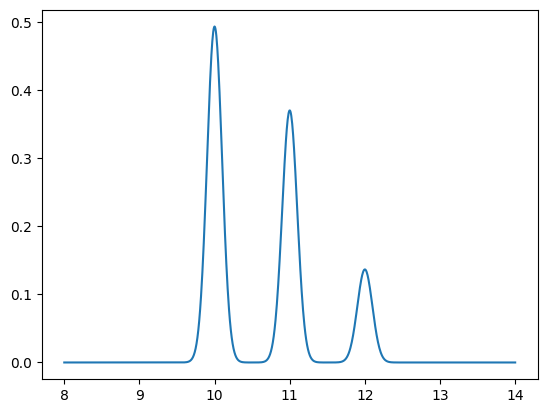

In [5]:
p = sns.lineplot(x=x_axis,y=y_pdf)


In [6]:
s = rng.choice(np.arange(len(y_pdf)),size=30,replace=False,p=y_pdf/np.sum(y_pdf))

[0.34811883 0.04489459 0.60698658]
[0.22610031 0.7019659  0.0719338 ]


<AxesSubplot: >

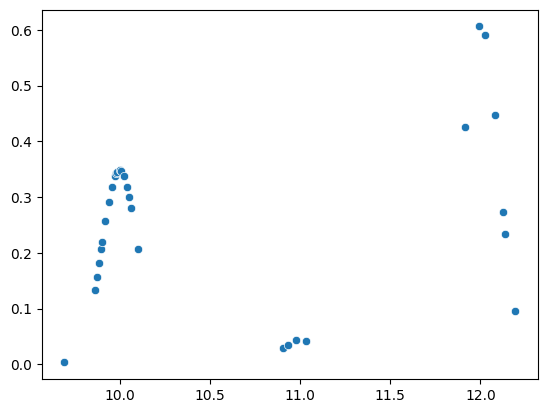

In [7]:
x_s = np.sort(x_axis[s])
y_s = f(x_s)
y_s_2 = f(x_s)
sns.scatterplot(x=x_s,y=y_s)


In [8]:
x_s_set = np.stack([x_s,x_s],axis=-1)
y_s_set = np.stack([y_s,y_s_2],axis=-1)

In [9]:
y_s_set.shape

(30, 2)

In [10]:
x_s.reshape((-1,1))-x_s

array([[ 0.        , -0.16816817, -0.18018018, -0.19219219, -0.2042042 ,
        -0.21021021, -0.22822823, -0.24624625, -0.26426426, -0.28228228,
        -0.28828829, -0.29429429, -0.30630631, -0.31231231, -0.33033033,
        -0.34834835, -0.36036036, -0.37237237, -0.40840841, -1.21321321,
        -1.23723724, -1.28528529, -1.33933934, -2.22222222, -2.3003003 ,
        -2.33033033, -2.38438438, -2.43243243, -2.44444444, -2.4984985 ],
       [ 0.16816817,  0.        , -0.01201201, -0.02402402, -0.03603604,
        -0.04204204, -0.06006006, -0.07807808, -0.0960961 , -0.11411411,
        -0.12012012, -0.12612613, -0.13813814, -0.14414414, -0.16216216,
        -0.18018018, -0.19219219, -0.2042042 , -0.24024024, -1.04504505,
        -1.06906907, -1.11711712, -1.17117117, -2.05405405, -2.13213213,
        -2.16216216, -2.21621622, -2.26426426, -2.27627628, -2.33033033],
       [ 0.18018018,  0.01201201,  0.        , -0.01201201, -0.02402402,
        -0.03003003, -0.04804805, -0.06606607, -0

In [23]:
coords = {
        "data_point":np.arange(len(x_s)),
        "peaks":np.arange(3),
    }

with pm.Model() as model:
    model.add_coord("data_point",coords["data_point"],mutable=True)
    model.add_coord("peaks",coords["peaks"])
    X = pm.MutableData("x",x_s, dims=("data_point"))
    Y = pm.MutableData("y",y_s, dims=("data_point"))
    _X = X.reshape((-1,1))
    mus = pm.Normal("mus",mu=[10,11,12],transform=pm.distributions.transforms.ordered,
                    initval=[10,11,12],sigma=10,dims=("peaks"))
    sigs = pm.Exponential("sigs",lam=10,dims=("peaks"))
    w = pm.Dirichlet("w",a=[35, 5, 60],dims=("peaks"))
    pred = pm.Deterministic("pred",var=pmath.sum(w*pmath.exp(-0.5*((_X-mus)/sigs)**2),axis=1),dims=("data_point"))

    e = pm.Exponential("e",lam=1)
    
    obs = pm.Normal("obs",mu=pred,sigma=e,observed=Y,dims=("data_point"))


In [24]:
with model as model:
    idata = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, sigs, w, e]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 351 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6062, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


array([<AxesSubplot: title={'center': 'mus\n0'}>,
       <AxesSubplot: title={'center': 'mus\n1'}>,
       <AxesSubplot: title={'center': 'mus\n2'}>], dtype=object)

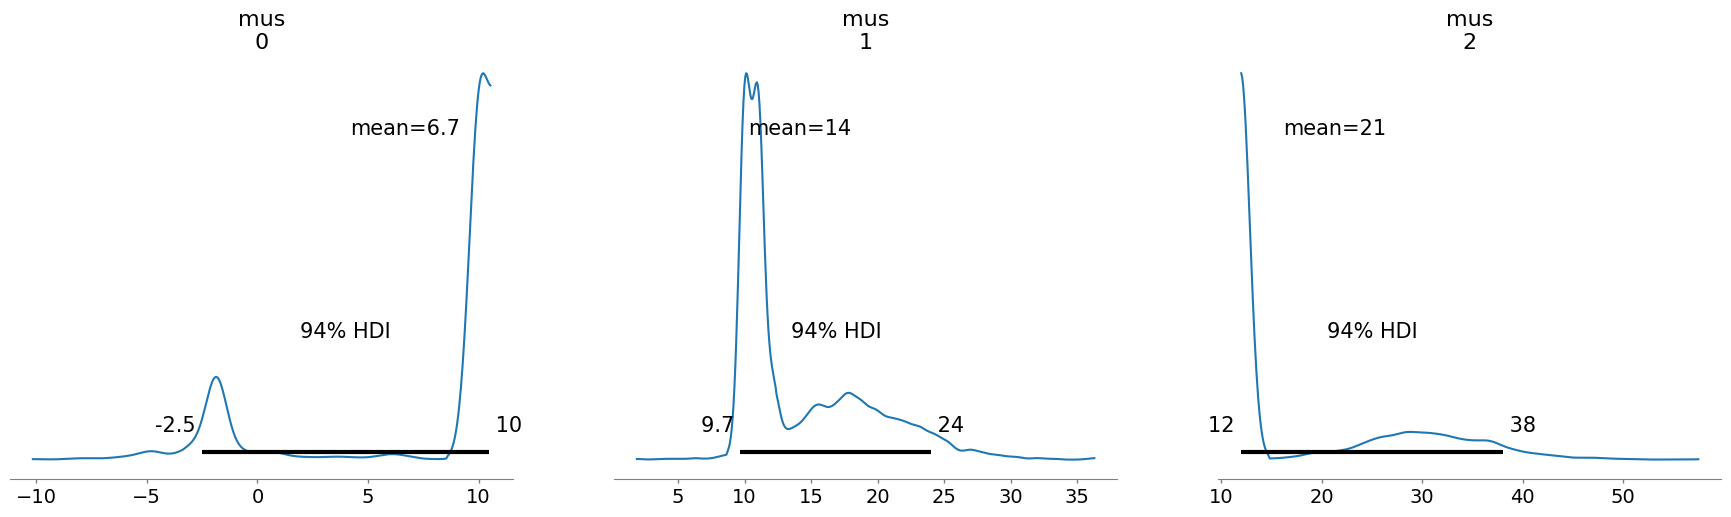

In [22]:
import arviz as az
az.plot_posterior(idata,var_names=["mus"])

In [ ]:
import arviz as az
with model as model:
    pm.sample_posterior_predictive(trace=idata,extend_inferencedata=True)


In [ ]:
az.plot_posterior(idata,var_names=["a","mus","sigs","w"],multimodal=True)

In [ ]:
with model as model:
    ind_new = np.random.choice(np.arange(len(x_axis)),size=40,replace=False,p=y_pdf/np.sum(y_pdf))
    X_new = np.sort(x_axis[ind_new])
    X_new_set = np.stack([X_new,X_new],axis=-1)
    Y_new = f(X_new)
    Y_new_2 = f(X_new)
    Y_new_set = np.stack([Y_new,Y_new_2],axis=-1)
    pm.set_data({
        "x":X_new_set,
        "y":Y_new_set
    },  coords={
        "data_point":np.arange(len(X_new)),
        "peaks":np.arange(3),
        "set":["set1","set2"]
    }
)

In [ ]:
with model as model:
    idata2 = pm.sample(10,tune=10)